In [1]:
import tensorflow as tf
import optuna
import pandas as pd
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

from tqdm import tqdm

In [2]:
def load_real_samples():
	# load dataset
	df = pd.read_csv('emnist-letters-train.csv', header=None)
	df = df[df[0] != -1]
	trainy = df[0]
	trainX = df.drop(0, axis=1)

	# augement x
	augmented_data = []
	for i in trainX.index:
		pixels = trainX.loc[i].values
		image = np.array(pixels).reshape(28,28)
		rotated_image = np.rot90(image, k=-1)
		flipped_horizontal = np.fliplr(rotated_image)
		augmented_data.append(flipped_horizontal)
	
	trainX = np.array(augmented_data)
	trainX = trainX.reshape(trainX.shape[0], 28, 28, 1)

	# convert from ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5

	# reset index
	trainy = trainy.reset_index(drop=True)

	return [X, trainy]

(trainX, trainy) = load_real_samples()
print(trainX.shape, trainy.shape)

(88800, 28, 28, 1) (88800,)


In [3]:
EPOCHS = 100

In [5]:
# Set up local functions
def generate_latent_points(latent_dim, n_samples, n_classes=26):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input], verbose=0)
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

def define_discriminator(in_shape=(28,28,1), n_classes=26, trial=None):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    # downsample
    d_conv_layers = trial.suggest_int('d_conv_layers', 1, 3)
    for i in range(d_conv_layers):
        d_num_filters = trial.suggest_int('d_num_filters_l{}'.format(i), 32, 128)
        merge = Conv2D(d_num_filters, (3,3), strides=(2,2), padding='same')(merge)
        merge = LeakyReLU(alpha=0.2)(merge)

    # flatten feature maps
    fe = Flatten()(merge)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)

    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    #print(model.summary())
    return model

def define_generator(latent_dim, n_classes=26, trial=None):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    
    # upsample to 14x14
    g_convT_layers = trial.suggest_int('g_convT_layers', 2, 4)

    current_size = 7
    target_size = 28

    for i in range(g_convT_layers):
        # Calculate the stride and kernel size based on remaining upsampling needed
        stride = 2 if current_size * 2 <= target_size else 1
        kernel_size = 4 if current_size * 2 <= target_size else 3  # Adjust based on stride
        
        g_num_filters = trial.suggest_int('g_num_filters_l{}'.format(i), 64, 128) if trial else 128  # Default value if trial is None
        merge = Conv2DTranspose(g_num_filters, (kernel_size,kernel_size), strides=(stride,stride), padding='same')(merge)
        merge = LeakyReLU(alpha=0.2)(merge)

        current_size *= stride

    # output
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(merge)

    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output

    # print shapes
    #print(gen_noise.shape)
    #print(gen_label.shape)
    #print(gen_output.shape)

    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

def learn(g_model, d_model, gan_model, dataset, latent_dim, n_batch=128, curr_epoch=0, max_epochs=100):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(1):
        # enumerate batches over the training set
        for j in tqdm(range(bat_per_epo), desc="Epoch {}/{}".format(curr_epoch, max_epochs)):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            # summarize loss on this batch
            #print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

def evaluate(g_model, d_model, dataset, latent_dim, n_batch=128):
    # calculate KL and JSD values
    [X_real, labels_real], _ = generate_real_samples(dataset, n_batch)
    [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
    [X_fake, _], _ = generate_fake_samples(g_model, latent_dim, n_batch)
    # use the discriminator to classify real and fake samples
    d_real = d_model.predict([X_real, labels_real], verbose=0)
    d_fake = d_model.predict([X_fake, labels_input], verbose=0)

    # calculate kl and js divergence
    kl_score = kl_divergence(d_real, d_fake)
    js_score = js_divergence(d_real, d_fake)

    print('KL divergence: %.3f' % kl_score)
    print('JS divergence: %.3f' % js_score)

    return kl_score, js_score

In [6]:
import numpy as np

def objective(trial):
    
            
    (trainX, trainy) = load_real_samples()

    # size of the latent space
    latent_dim = 100

    # create the discriminator
    d_model = define_discriminator(trial=trial)
    # create the generator
    g_model = define_generator(latent_dim, trial=trial)
    # create the gan
    gan_model = define_gan(g_model, d_model)

    # train model
    with tf.device('/device:GPU:0'):
        epochs = trial.suggest_int('epochs', 10, 50)
        
        # print trial
        print(f"Trial {trial.number} with parameters {trial.params}")

        for _ in range(epochs):
            learn(g_model, d_model, gan_model, [trainX, trainy], latent_dim, curr_epoch=_, max_epochs=epochs)

        # evaluate model
        kl_score, js_score = evaluate(g_model, d_model, [trainX, trainy], latent_dim)
        return kl_score

    


In [7]:
study = optuna.create_study(direction='minimize', study_name='emnist_letters_gan', storage='sqlite:///emnist_letters_gan10.db', load_if_exists=True)

#study.optimize(objective, n_trials=1)

#save to csv
df = study.trials_dataframe()
df.to_csv('emnist_letters_gan10.csv')

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-03 04:57:07,317] Using an existing study with name 'emnist_letters_gan' instead of creating a new one.


Number of finished trials:  28
Best trial:
  Value:  22.896785736083984
  Params: 
    d_conv_layers: 3
    d_num_filters_l0: 34
    d_num_filters_l1: 33
    d_num_filters_l2: 124
    g_convT_layers: 4
    g_num_filters_l0: 124
    g_num_filters_l1: 64
    g_num_filters_l2: 66
    g_num_filters_l3: 65
    epochs: 20


# Generate Images

In [13]:
best_params = trial.params

import json
# save best params
with open('best_params.json', 'w') as f:
    json.dump(best_params, f)

# save best model
g_model = define_generator(100, trial=trial)
print(g_model.summary())
g_model.save('best_generator.h5')

d_model = define_discriminator(trial=trial)
d_model.save('best_discriminator.h5')

gan_model = define_gan(g_model, d_model)
gan_model.save('best_gan.h5')

# evaluate model
kl_score, js_score = evaluate(g_model, d_model, [trainX, trainy], 100)
print("KL divergence: ", kl_score)
print("JS divergence: ", js_score)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 6272)         633472      ['input_6[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 50)        1300        ['input_5[0][0]']                
                                                                                            

1/1 [==============================] - 0s 18ms/step


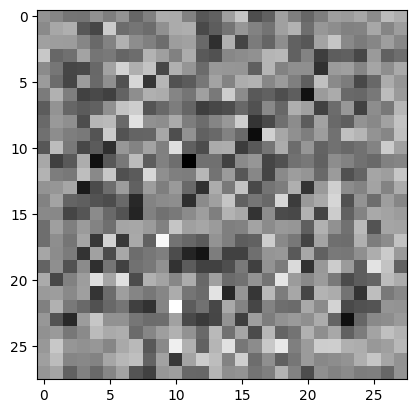

In [18]:
image = g_model.predict([np.random.randn(100).reshape(1,100), np.array([3])])

import matplotlib.pyplot as plt
plt.imshow(image[0].reshape(28,28), cmap='gray')